In [20]:

import sys
sys.path.append('/eos/home-i02/h/hsharma/.local/lib/python3.9/site-packages')
#sys.path.append('/cvmfs/sft.cern.ch/lcg/views/LCG_104a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages')


In [21]:
import torch
from pzflow import Flow
from pzflow.examples import get_twomoons_data
import ROOT
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import uproot3 as uproot

import math
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ks_2samp


Welcome to JupyROOT 6.28/06


/cvmfs/sft.cern.ch/lcg/views/LCG_104a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_104a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


In [22]:
import jax
import optax
import pzflow
print(jax.__version__, optax.__version__, pzflow.__version__)

0.4.8 0.1.7 3.1.2


In [46]:
pathTOFile="/eos/user/h/hsharma/AMPT_Data/ampt_AuAu_1000Ev.root"
# pathTOFile="/eos/user/h/hsharma/XicBDTapply/output_BDT_sigLc_bkgXic_combined.root"
file=uproot.open(pathTOFile)
file.keys()
tree=file.get('AMPT')
df_total=tree.pandas.df()

#df_total = df_total.astype(float32)
#-----------------

df_total=df_total.rename(columns={'Event.nevent': 'evID', 'Event.impactpar':'impPar','Event.multi':'multi' })
# df_total=df_total.query('evID<500 & (abs(PDG)==211 | abs(PDG)==321 | abs(PDG)==2212) & impPar>0 & impPar<3 ' ) ## with PID cuts
df_total=df_total.query('evID<500 & impPar>0 & impPar<3 ' )  ## Only Event cuts
df_total = df_total.reset_index(drop=True)
df_total

,evID,Event.nrun,multi,impPar,Event.NpartP,Event.NpartT,Event.NELP,Event.NINP,Event.NELT,Event.NINT,Event.nDummy,PDG,Px,Py,Pz,Mass,X,Y,Z,Time
0,8,1,6856,2.2280,170,174,8,162,5,169,5.0153,2112,0.000,0.000,99.995598,0.940,4.03,-5.54,2.000000e-01,2.000000e-01
1,8,1,6856,2.2280,170,174,8,162,5,169,5.0153,2112,0.000,0.000,-99.995598,0.940,4.65,4.59,-2.000000e-01,2.000000e-01
2,8,1,6856,2.2280,170,174,8,162,5,169,5.0153,2212,0.000,0.000,-99.995598,0.940,0.47,7.77,-2.000000e-01,2.000000e-01
3,8,1,6856,2.2280,170,174,8,162,5,169,5.0153,2212,0.000,0.000,-99.995598,0.940,-4.09,5.39,-2.000000e-01,2.000000e-01
4,8,1,6856,2.2280,170,174,8,162,5,169,5.0153,2212,0.000,0.000,-99.995598,0.940,-5.86,3.28,-2.000000e-01,2.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146386,482,1,7654,2.4267,180,182,4,176,3,179,5.5892,2112,-0.627,-0.084,37.286900,0.940,-3.38,1.97,4.772500e+02,4.771300e+02
146387,482,1,7654,2.4267,180,182,4,176,3,179,5.5892,-3122,0.382,0.517,-88.635597,1.116,2100.00,2600.00,-5.100000e+05,5.100000e+05
146388,482,1,7654,2.4267,180,182,4,176,3,179,5.5892,22,0.201,0.420,-30.975500,0.000,280000.00,170000.00,-2.300000e+07,2.300000e+07
146389,482,1,7654,2.4267,180,182,4,176,3,179,5.5892,2212,-0.319,0.404,-53.809502,0.938,-3.96,7.89,-9.805500e+02,9.804600e+02


In [48]:
df_total.query('evID==8').shape[0]

6856

In [53]:

list4vec=['Px', 'Py', 'Pz', 'Mass','PDG']
listPxPyPzM=['Px', 'Py', 'Pz', 'Mass','evID']
list4VecE=['Px', 'Py', 'Pz', 'E']

df_total=df_total[listPxPyPzM]
df_total


,Px,Py,Pz,Mass,evID
50,0.232,0.136,-0.0402,0.000,8
51,0.008,-0.118,-0.0273,0.000,8
52,0.007,0.036,0.0116,0.000,8
53,0.004,-0.010,-0.0038,0.000,8
54,0.002,0.008,-0.0032,0.000,8
...,...,...,...,...,...
145798,0.183,0.009,0.0017,0.140,482
145816,-1.049,0.341,0.3191,0.940,482
145839,-0.462,-0.982,0.0830,0.940,482
145857,2.182,0.207,0.0906,0.494,482


array([[<Axes: title={'center': 'Pt'}>, <Axes: title={'center': 'Eta'}>,
        <Axes: title={'center': 'Phi'}>],
       [<Axes: title={'center': 'P'}>, <Axes: title={'center': 'v2Cos'}>,
        <Axes: title={'center': 'v2Mom'}>],
       [<Axes: title={'center': 'Theta'}>, <Axes: >, <Axes: >]],
      dtype=object)

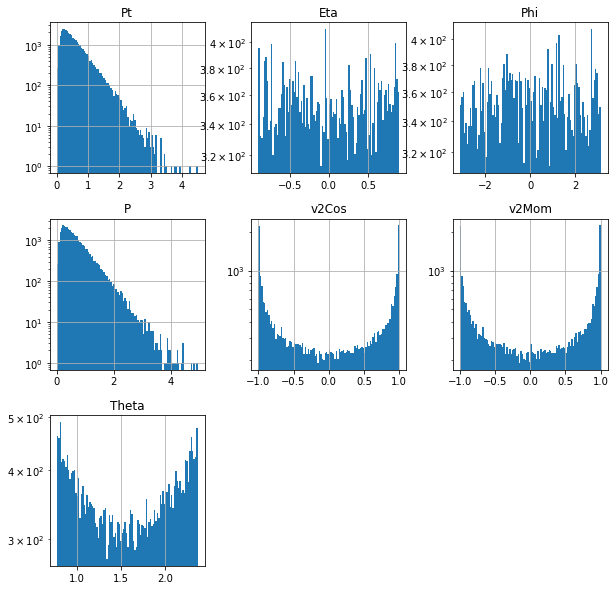

In [54]:
def evalKinVars(df):    
    pt_list = []
    mass_list = []
    eta_list = []
    phi_list = []
    v2cos_list = []
    v2mom_list = []
    theta_list = []

    df['P']  = np.sqrt(df['Px']*df['Px'] + df['Py']*df['Py'] + df['Pz']*df['Pz'])
    df['E']  = np.sqrt(df['P']*df['P'] + df['Mass']*df['Mass'] )


    for index, row in df.iterrows():
        # Create a TLorentzVector instance
        lv = ROOT.TLorentzVector()

        # Set the four-vector components
        lv.SetPxPyPzE(row['Px'], row['Py'], row['Pz'], row['E'])

        # Compute four-vector properties
        pt = lv.Pt()  # Transverse momentum
        # mass = lv.M()  # Invariant mass
        eta = lv.Eta()  # Pseudorapidity
        phi = lv.Phi()  # Azimuthal angle
        theta = lv.Theta()  # Azimuthal angle
        v2cos = math.cos(2 * phi)
        v2mom = (row['Px']*row['Px'] - row['Py']*row['Py']) / (row['Px']*row['Px'] + row['Py']*row['Py'])

        # Append computed values to lists
        pt_list.append(pt)
        # mass_list.append(mass)
        eta_list.append(eta)
        phi_list.append(phi)
        v2cos_list.append(v2cos)
        v2mom_list.append(v2mom)
        theta_list.append(theta)


    # Add new columns to the DataFrame
    df['Pt'] = pt_list
    #df['InvMass'] = mass_list
    df['Eta'] = eta_list
    df['Phi'] = phi_list
    df['v2Cos'] = v2cos_list
    df['v2Mom'] = v2mom_list
    df['Theta'] = theta_list


evalKinVars(df_total)

# plotCols=['P','E']
# df_total.hist(plotCols,bins=100,figsize=(5,5),log=1)



# df_total = df_total.query('abs(v2Mom) < 0.9')

df_total = df_total.query('abs(Eta) < 0.9')

plotCols=['Pt','Eta','Phi','P','v2Cos','v2Mom','Theta']
# plotCols=['P','P1']
df_total.hist(plotCols,bins=100,figsize=(10,10),log=1)


In [56]:
df4Vec = df_total[['Px','Py','Pz','E']]
df3PM = df_total[['Px','Py','Pz','Mass','evID']]

flow = Flow(["Px", "Py","Pz","Mass","evID"])

In [57]:
%%time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data=df3PM
losses = flow.train(data, verbose=True)



Training 100 epochs 
Loss:
(0) 14.3142
(1) 7.2295
(6) 3.4595
(11) 2.9536
(16) 2.7450
(21) 3.1888
(26) 2.7743
(31) 2.2957
(36) 2.4016
(41) 1.9257
(46) 3.7274
(51) 2.0918
(56) 1.8209
(61) 1.6290
(66) 1.6761
(71) 1.5761
(76) 2.1387
(81) 2.2699
(86) 1.6812
(91) 1.8614
(96) 1.5500
(100) 2.0402
CPU times: user 4min 51s, sys: 34.4 s, total: 5min 25s
Wall time: 2min 44s


In [58]:
data=df3PM

# 80% for the training set
train_set = data[: int(0.8 * len(data))]

# 20% for the training set
val_set = data[int(0.8 * len(data)) :]

train_losses, val_losses = flow.train(train_set, val_set, verbose=True)

Training 100 epochs 
Loss:
(0) 1.1452  1.2914
(1) 3.2656  3.6427
(6) 1.1871  3.8964
(11) 1.3282  5.7045
(16) 1.3498  6.1447
(21) 1.2244  5.7237
(26) 0.6546  5.1030
(31) 0.7014  5.7253
(36) 1.7113  7.0673
(41) 2.6531  9.6123
(46) 2.0716  9.7717
(51) 1.3854  9.4872
(56) 1.2372  9.5344
(61) 0.6901  9.0084
(66) 0.7641  9.5216
(71) 1.3152  11.0519
(76) 1.4895  9.9267
(81) 1.6285  9.6312
(86) 1.1922  9.2432
(91) 2.0244  9.2919
(96) 1.6912  7.6487
(100) 1.8122  8.9012


In [59]:
dfGen = flow.sample(10000, seed=0)


In [60]:
evalKinVars(dfGen)

In [61]:

def plot_comparison(df1, df2, label1, label2, columns_to_plot, log_scale=True, x_ranges=None, xticks=None, normalize=True):
    num_cols = len(columns_to_plot)
    num_hist_rows = int(np.ceil(num_cols ** 0.5))  # Use ceiling to ensure enough rows

    # Specify the number of bins
    num_bins = 50

    # Create a grid of plots with an extra column for the heatmaps
    fig = plt.figure(figsize=(6 * (num_hist_rows + 1), 4 * num_hist_rows))
    gs = fig.add_gridspec(num_hist_rows, num_hist_rows + 1, width_ratios=[1] * num_hist_rows + [2])

    axs = np.array([[fig.add_subplot(gs[i, j]) for j in range(num_hist_rows + 1)] for i in range(num_hist_rows)])

    legend_plotted = False  # Flag to track if legend has been plotted
    
    # Plot histograms for each column from both dataframes
    for i, column in enumerate(columns_to_plot):
        row_idx = i // num_hist_rows  # Calculate the row index for the subplot
        col_idx = i % num_hist_rows   # Calculate the column index for the subplot
        x_min1 = df1[column].min()
        x_min2 = df2[column].min()
        x_max1 = df1[column].max()
        x_max2 = df2[column].max()
        x_min = min(x_min1, x_min2)
        x_max = max(x_max1, x_max2)
        x_range = (x_min, x_max)
        
        # Calculate KS statistic
        ks_stat, ks_pvalue = ks_2samp(df1[column], df2[column])
        
        axs[row_idx, col_idx].hist(df1[column], bins=num_bins, alpha=1, label=label1, density=normalize, histtype='step', range=x_range)
        axs[row_idx, col_idx].hist(df2[column], bins=num_bins, alpha=0.4, label=label2, density=normalize, color='orange', range=x_range)
        axs[row_idx, col_idx].set_xlabel('')
        axs[row_idx, col_idx].set_ylabel('')
        axs[row_idx, col_idx].set_title(column)
        
        # Add KS statistic text inside the panel
        text_x = x_min + (x_max - x_min) * 0.05  # Positioning text a bit to the right of the left edge
        text_y = axs[row_idx, col_idx].get_ylim()[1] * 0.85  # Positioning text a bit below the top edge
        axs[row_idx, col_idx].text(text_x, text_y, f'KS: {ks_stat:.2f}', fontsize=12, verticalalignment='top')
        
        if log_scale:
            axs[row_idx, col_idx].set_yscale('log')
            
        # Set x-axis range if provided
        if x_ranges and column in x_ranges:
            axs[row_idx, col_idx].set_xlim(x_ranges[column])
        
        # Set x-axis ticks if provided
        if xticks and column in xticks:
            axs[row_idx, col_idx].set_xticks(xticks[column])

        # Plot the legend only once
        if not legend_plotted:
            axs[row_idx, col_idx].legend()
            legend_plotted = True
            
    # Hide any empty subplots
    for i in range(len(columns_to_plot), num_hist_rows * num_hist_rows):
        row_idx = i // num_hist_rows
        col_idx = i % num_hist_rows
        axs[row_idx, col_idx].axis('off')

    # Calculate correlation matrices
    corr_matrix_df1 = df1[columns_to_plot].corr()
    corr_matrix_df2 = df2[columns_to_plot].corr()

    # Plot correlation matrices as heatmaps
    sns.heatmap(corr_matrix_df1, ax=axs[0, -1], annot=True, cmap='Blues', fmt=".2f", vmin=-1, vmax=1)
    axs[0, -1].set_title('MC')

    sns.heatmap(corr_matrix_df2, ax=axs[1, -1], annot=True, cmap='Blues', fmt=".2f", vmin=-1, vmax=1)
    axs[1, -1].set_title('ML model')

    # Hide the extra heatmap subplot if not needed
    for j in range(2, num_hist_rows):
        axs[j, -1].axis('off')
            
    # Adjust layout
    plt.tight_layout() 
    plt.subplots_adjust(wspace=0.4, hspace=0.4) 

    # Show the plot
    plt.show()

# Example usage
# cuts = 'fPt > 2 & fCpa < 1 & fCpaXY < 1 & fCt > 0 & fDecayLength > 0.0'


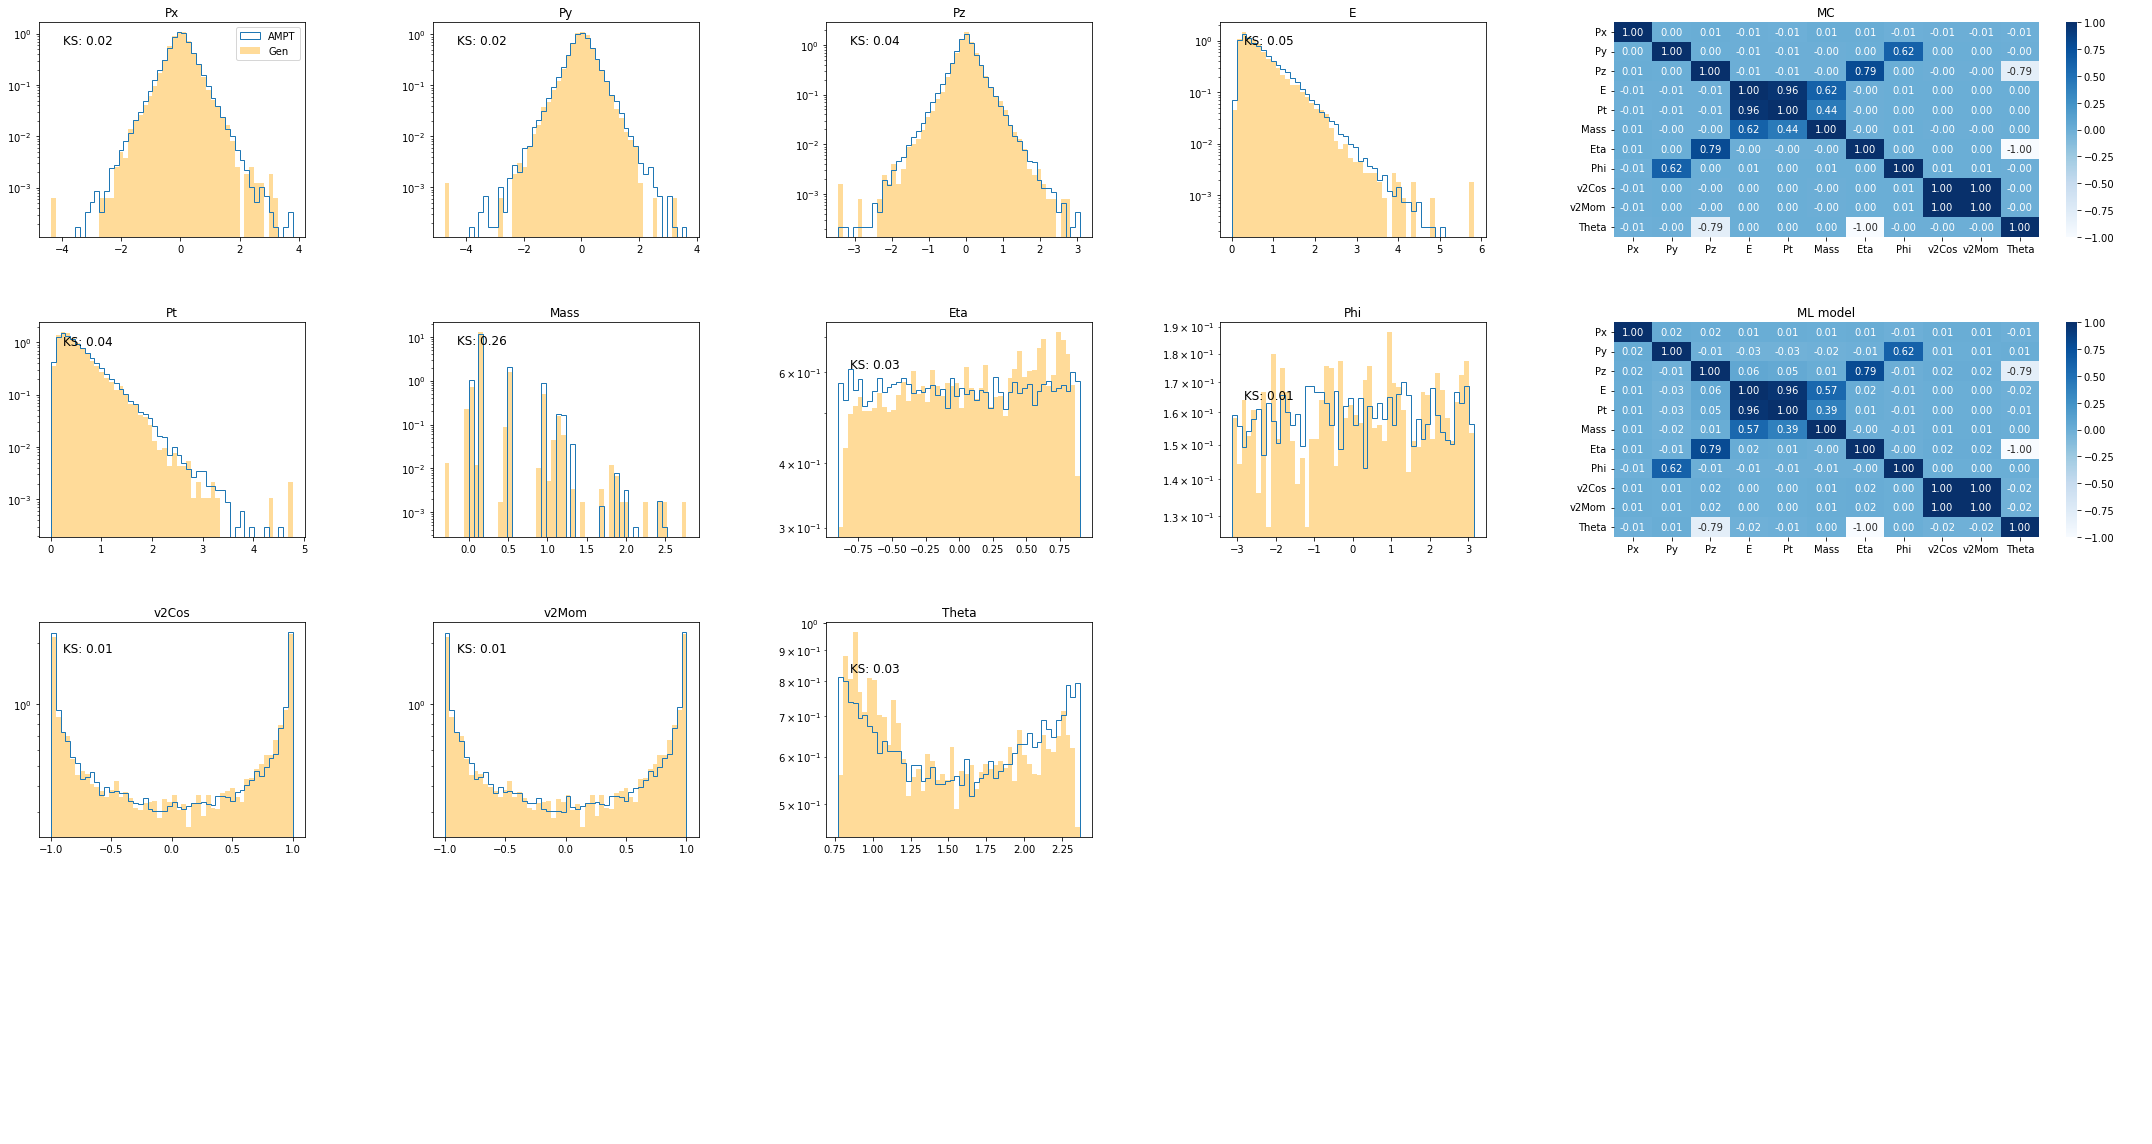

In [62]:
# varsToCompare=['Pt','InvMass','Phi','Eta']
# df_ampt=df_total[varsToCompare]
# df_ml=df_fake[varsToCompare]

dfGen = dfGen.query('abs(Eta)<0.9')

cols = ['Px', 'Py', 'Pz', 'E', 'Pt', 'Mass', 'Eta', 'Phi', 'v2Cos', 'v2Mom', 'Theta']

plot_comparison(df_total, 
                dfGen,
                'AMPT',
                'Gen',
                cols,
                log_scale=True,
                x_ranges=None,
                xticks=None,
                normalize=True)


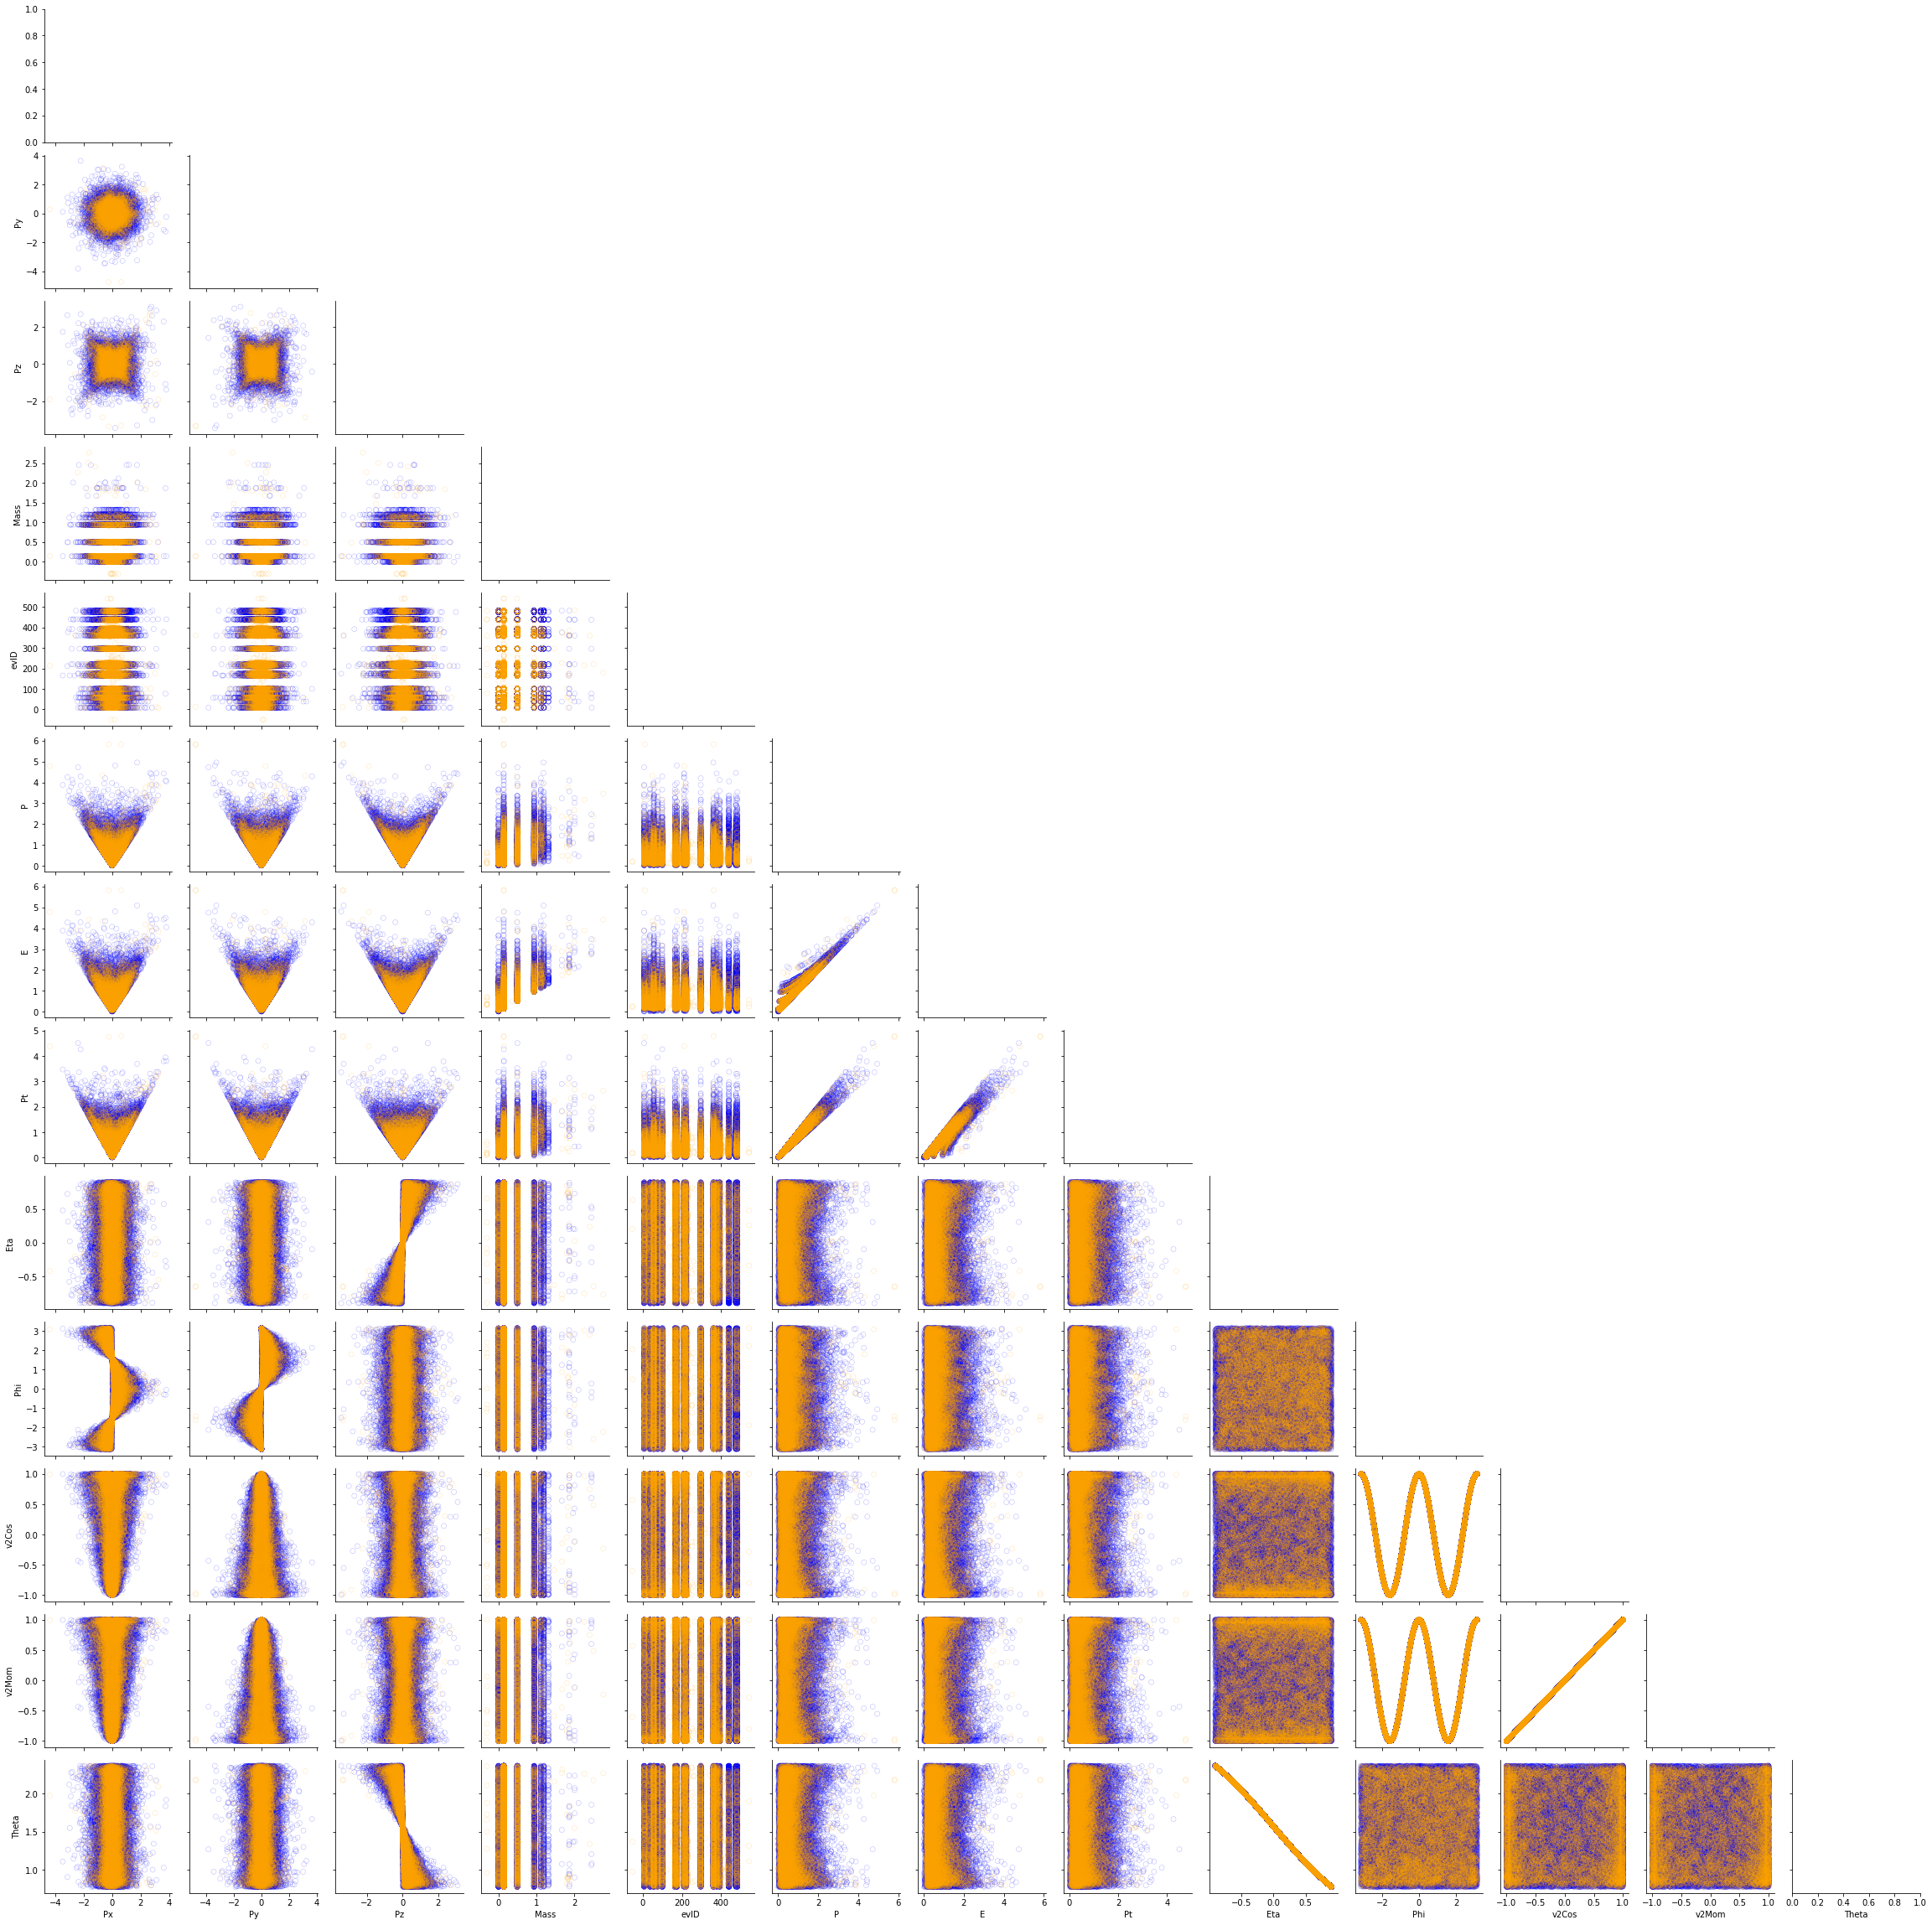

In [63]:
# Create PairGrid for df_total
df1=df_total
df2=dfGen

g = sns.PairGrid(df1, diag_sharey=False, corner=True)

# Map scatterplot for df_total
# g.map_lower(sns.scatterplot)
# g.map_lower(lambda x, y, **kwargs: sns.scatterplot(x=x, y=y, facecolors='none', edgecolor='b', alpha=0.5, **kwargs))
g.map_lower(lambda x, y, **kwargs: sns.scatterplot(x=x, y=y, facecolors='none', edgecolor='blue', alpha=0.3, **kwargs))

# g.map_diag(sns.kdeplot)


# Overlay scatterplot for df_fake
for i, j in zip(*plt.np.triu_indices_from(g.axes, 1)):
    sns.scatterplot(data=df2, x=df2.columns[i], y=df2.columns[j], 
                    ax=g.axes[j, i], facecolors='none', edgecolor='orange',alpha=0.3)  # You can adjust color and marker as needed

# Display the plot
plt.show()